In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers


In [2]:
# read in data
data_location = 'data'
outlooks, pph, reports = read_datasets(data_location, 'labelled')

reading outlooks
reading pph
reading storm reports


In [3]:
def consolidate_date(outlooks, pph, reports):
    earliest_date = max(min(outlooks['DATE']), min(pph['time']), min(reports['DATE'])) #TODO first two days of outlook dataset don't have day 3 forecast. but probably ok since not mdt
    latest_date = min(max(outlooks['DATE']), max(pph['time']), max(reports['DATE']))
    reports = reports[reports['DATE'] <= latest_date]
    reports = reports[reports['DATE'] >= earliest_date]
    outlooks = outlooks[outlooks['DATE'] <= latest_date]
    outlooks = outlooks[outlooks['DATE'] >= earliest_date]
    all_pph_dates = pph['time']
    pph_dates = all_pph_dates[all_pph_dates <= latest_date]
    pph_dates = pph_dates[pph_dates >= earliest_date]
    pph = pph.sel(time = pph_dates)
    return(outlooks, pph, reports)

(outlooks, pph, reports) = consolidate_date(outlooks, pph, reports)


In [62]:
label_names = ['MAX_CAT', 'RAMP_CAT', 'SEASON', 'REGION', 'RAMP_UP', 'RAMP_DOWN', 
               'PPH_CAT', 'PPH_NUM',
               'REPORT_NUM', 'TOR_NUM', 'WIND_NUM', 'HAIL_NUM', 
               'TOR_F', 'WINDSP_NUM', 'HAILSZ_NUM', 
               'BS_NUM', 'NEIGH_NUM', 'RMSE_NUM']

category_dict = {
    'NONE' : -1,
    'TSTM': 0,
    'MRGL': 1,
    'SLGT': 2,
    'ENH': 3,
    'MDT': 4,
    'HIGH': 5
}

ramp_dict = {
    'up': 0,
    'down': 1,
    'both': 2,
    'neither': 3
}

season_dict = {
    'Winter': 0,
    'Spring': 1,
    'Summer': 2,
    'Fall': 3
}

region_dict = {
    'NONE': -1,
    'West': 0,
    'Great Plains': 1,
    'Midwest': 2,
    'Northeast': 3,
    'South': 4
}

ramp_up_dict = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6
}

ramp_down_dict = {
    '0': 0,
    '-1': 1,
    '-2': 2,
    '-3': 3,
    '-4': 4,
    '-5': 5,
    '-6': 6
}

pph_dict = {
    'ZERO': 0,
    'TSTM': 1,
    'MRGL': 2,
    'SLGT': 3,
    'ENH': 4,
    'MDT': 5,
    'HIGH': 6
}

tor_dict = {
    'NONE': -1,
    'EFU': 0,
    '(E)F0': 1,
    '(E)F1': 2,
    '(E)F2': 3,
    '(E)F3': 4,
    '(E)F4': 5,
    '(E)F5': 6
}

dicts = [category_dict, ramp_dict, season_dict, region_dict, ramp_up_dict, ramp_down_dict, 
         pph_dict, None, 
         None, None, None, None, 
         tor_dict, None, None,
         None, None, None] 

steps = [1, 1, 1, 1, 1, 1, 
         1, 10, 
         100, 25, 100, 50, 
         1, 10, 1, 
         .0025, .0025, .01]

written_labels = ['Categorical Risk', 'Ramp', 'Season', 'Region', 'Ramp Up', 'Ramp Down', 
                  'Max PPH', 'Max PPH',
                  'Total Storm Reports', 'Tornado Reports', 'Wind Reports', 'Hail Reports',
                  'Max Tornado Rating', 'Max Wind Speed (kt)', 'Max Hail Size (in)',
                  'Brier Score', 'Neighborhood Brier Score', 'RMSE']


In [5]:
def plot_distribution(pph, label_name, label_dict, written_label, titlestring, save_location, bins = 20, show=False):
    if label_dict == None:
        plt.hist(pph[label_name].values, bins = bins)
    else:
        labels = pph[label_name]
        label_counts = labels.groupby(labels).count()
        def sort_order(key):
            return label_dict[str(key[0])]
        sorted_labels, sorted_counts = zip(*sorted(zip(list(label_counts[label_name].values), label_counts.values), key = sort_order))
        plt.bar(sorted_labels, sorted_counts)  
    plt.xlabel(written_label)
    plt.title('Number of ' + titlestring + ' Days With Each '  + written_label)
    plt.ylabel("Number of Days")
    if save_location != None:
        plt.savefig(save_location + '/' + written_label + '_distribution.png')
    if show:
        plt.show()
    plt.close()

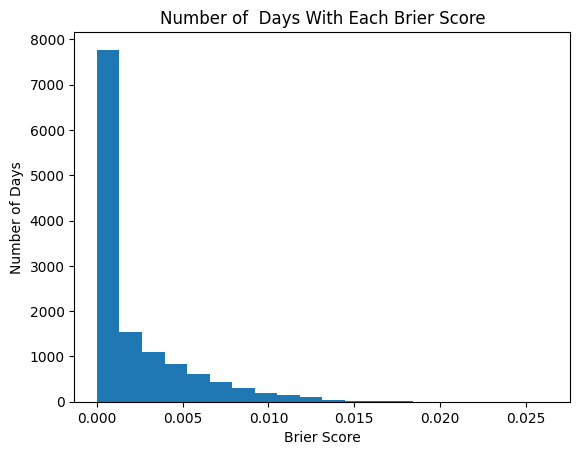

In [6]:
plot_distribution(pph, 'BS_NUM', None, 'Brier Score', '', None, show = True) # Seems to work, reverify once num_reports is fixed

In [66]:
def plot_distribution_2d(pph, label_1, label_2, label_1_string, label_2_string, dict_1, dict_2, titlestring, save_location, show=False, defaultbins = 10, step_1 = 1, step_2 = 1):
# plot 2d heatmap for any 2 labels

    data1 = []
    data2 = []

    for i in range(len(pph[label_1])):
        if dict_1 != None:
            data1.append(dict_1[str(pph[label_1].values[i])])
        else: 
            data1.append(pph[label_1].values[i])
        if dict_2 != None:
            data2.append(dict_2[str(pph[label_2].values[i])])
        else:
            data2.append(pph[label_2].values[i])

    
    if dict_1 != None:
        max1 = max(dict_1.values())
        min1 = min(dict_1.values())
        bins1 = np.linspace(min1-.5, max1+.5, 2+max1-min1)
        irange = bins1.size-1
    else:
        if ((max(data1) - min(data1))/step_1).is_integer():
            m = 2
        else: 
            m = 1
            
        bins1 = np.insert(np.arange(step_1 * round(min(data1)/step_1), max(data1)+m*step_1, step_1), 0, 0)
        
        if isinstance(data1[1], numbers.Integral):
            bins1[1] = bins1[1] + 1
        else:
            bins1[1] = bins1[1] + .00000000001
        num_bins1 = len(bins1)-1
        irange = num_bins1

    if dict_2 != None:
        max2 = max(dict_2.values())
        min2 = min(dict_2.values())
        bins2 = np.linspace(min2-.5, max2+.5, 2+max2-min2)
        jrange = bins2.size-1
    else:
        if ((max(data2) - min(data2))/step_2).is_integer():
            m = 2
        else: 
            m = 1
        bins2 = np.insert(np.arange(step_2 * round(min(data2)/step_2), max(data2)+m*step_2, step_2), 0, 0)
        if isinstance(data2[1], numbers.Integral):
            bins2[1] = bins2[1] + 1
        else:
            bins2[1] = bins2[1] + .00000000001
        num_bins2 = len(bins2)-1
        jrange = num_bins2

    heatmap = np.histogram2d(data1, data2, bins = (bins1, bins2))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)

    for i in range(irange): 
        for j in range(jrange): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    if dict_1 != None:
        plt.yticks(range(len(list(dict_1.values()))), labels=list(dict_1.keys()))
    else:
        labels = [s + '+' for s in heatmap[1][range(num_bins1)].astype(str)]
        labels[0] = '0'
        if isinstance(data1[1], numbers.Integral):
            labels[1] = '1+'
        else:
            labels[1] = '0+'
        plt.yticks(range(num_bins1), labels = labels) 
        plt.yticks(fontsize=8)
    if dict_2 != None:
        plt.xticks(range(len(list(dict_2.values()))), labels=list(dict_2.keys()))
    else:
        labels = [s + '+' for s in heatmap[2][range(num_bins2)].astype(str)]
        labels[0] = '0'
        if isinstance(data2[1], numbers.Integral):
            labels[1] = '1+'
        else:
            labels[1] = '0+'
        plt.xticks(range(num_bins2), labels = labels)
        plt.xticks(fontsize=8)

    plt.ylabel(label_1_string)
    plt.xlabel(label_2_string)

    plt.title("Number of " + titlestring + " Days with each Combination of " + label_1_string + " and " +  label_2_string)
    if save_location != None:
        plt.savefig(save_location + '/' + label_1_string + '_' + label_2_string + '_distribution.png')
    if show:
        plt.show()
    plt.close()

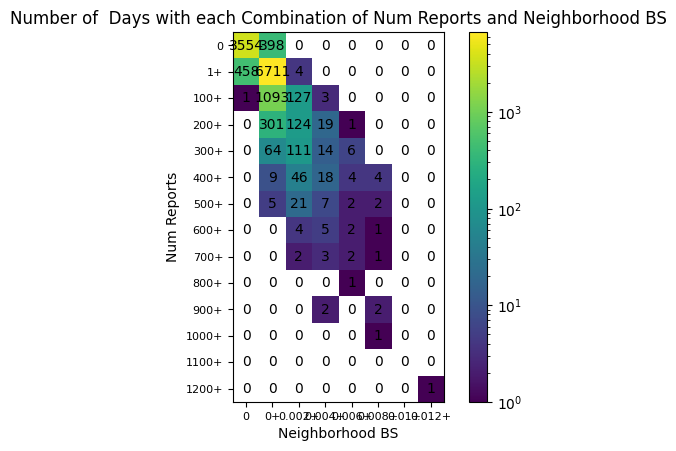

In [59]:
plot_distribution_2d(pph, 'REPORT_NUM', 'NEIGH_NUM', 'Num Reports', 'Neighborhood BS', None, None, '', None, show = True, step_1 = 100, step_2 = .002)

In [52]:
# THIS NEEDED TO BE RERUN TWICE FOR SOME REASON

# moderate and up days only:
all_pph_dates = pph['time']
mdt_pph_dates = all_pph_dates[pph['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_pph = pph.sel(time = mdt_pph_dates)




# dates since new categorical system 
new_cutoff = '201410230000'
new_pph_dates = all_pph_dates[all_pph_dates >= new_cutoff]
new_pph = pph.sel(time = new_pph_dates)

# Moderate dates in new system
mdt_new_pph_dates = mdt_pph_dates[mdt_pph_dates >= new_cutoff]
mdt_new_pph = pph.sel(time = mdt_new_pph_dates)


# dates since day 3 added
day3_cutoff = '200203300000'
day3_pph_dates = all_pph_dates[all_pph_dates >= day3_cutoff]
day3_pph = pph.sel(time = day3_pph_dates)

# Moderate dates since day 3 added
mdt_day3_pph_dates = mdt_pph_dates[mdt_pph_dates >= day3_cutoff]
mdt_day3_pph = pph.sel(time = mdt_day3_pph_dates)


# dates since early day 2 added
day21_cutoff = '199707100000'
day21_pph_dates = all_pph_dates[all_pph_dates >= day21_cutoff]
day21_pph = pph.sel(time = day21_pph_dates)


# Moderate dates since early day 2 added
mdt_day21_pph_dates = mdt_pph_dates[mdt_pph_dates >= day21_cutoff]
mdt_day21_pph = pph.sel(time = mdt_day21_pph_dates)


# dates since late day 2 added
day22_cutoff = '199504040000'
day22_pph_dates = all_pph_dates[all_pph_dates >= day22_cutoff]
day22_pph = pph.sel(time = day22_pph_dates)

# Moderate since late day 2 added
mdt_day22_pph_dates = mdt_pph_dates[mdt_pph_dates >= day22_cutoff]
mdt_day22_pph = pph.sel(time = mdt_day22_pph_dates)



In [50]:
def make_plots(pph, label_names, dicts, written_labels, shortstring, titlestring, show=False):
    
    for i in range(len(written_labels)):
        plot_distribution(pph, label_names[i], dicts[i], written_labels[i], titlestring, 'plots/label_distributions/'+ shortstring+'/1d/', show=show)

    for i in range(len(label_names)):
        for j in range(i):
            plot_distribution_2d(pph, label_names[i], label_names[j], written_labels[i], written_labels[j], dicts[i], dicts[j], titlestring, 'plots/label_distributions/'+ shortstring+'/2d/', show=show, step_1 = steps[i], step_2 = steps[j])

In [68]:
make_plots(pph, label_names, dicts, written_labels, 'all', 'All')
make_plots(mdt_pph, label_names, dicts, written_labels, 'mdt', 'Moderate')

make_plots(new_pph, label_names, dicts, written_labels, 'new', 'New')
make_plots(mdt_new_pph, label_names, dicts, written_labels, 'mdt_new', 'Moderate New')

make_plots(day3_pph, label_names, dicts, written_labels, 'day3', 'Since 2002')
make_plots(mdt_day3_pph, label_names, dicts, written_labels, 'mdt_day3', 'Moderate Since 2002')

make_plots(day21_pph, label_names, dicts, written_labels, 'day21', 'Since 1997')
make_plots(mdt_day21_pph, label_names, dicts, written_labels, 'mdt_day21', 'Moderate Since 1997')

make_plots(day22_pph, label_names, dicts, written_labels, 'day22', 'Since 1995')
make_plots(mdt_day22_pph, label_names, dicts, written_labels, 'mdt_day22', 'Moderate Since 1995')


# OLD NON-GENERALIZED PLOTTING OF RAMPS / SCRATCH WORK

Investigate: old ramp ups by 5? Why lots of 5 and not 4? And none region, make sure no PPH.

In [ ]:
test = outlooks[outlooks['REGION'] != 'NONE']
test[test['DATE'] <= '199203160000']

In [ ]:
test_outlooks = outlooks[outlooks['MAX_CAT'] == 'SLGT']
test_outlooks = test_outlooks[test_outlooks['RAMP_UP'] == 3]
set(test_outlooks['DATE'])

In [ ]:
outlooks[outlooks['DATE'] == '200208030000']

In [ ]:
# TODO: make function that plots all 3 outlooks, PPH, and reports for one day to spotcheck
# with utils_plotting functions
def plot_day(datestring, outlooks, pph, reports):
    outlooks_day = outlooks[outlooks['DATE'] == datestring]
    pph_day = pph.sel(time=datestring)
    reports_day = reports[reports['DATE'] == datestring]
    
    print('plotting outlooks')
    plot_outlooks_day(outlooks_day, 'plots/daily/'+datestring+'/outlooks', ['CATEGORICAL'], show=True)
    print('plotting pph')
    plot_pph_day(pph_day, 'plots/daily/'+datestring+'/pph', ['total'], show=True, sig = False)
    #print('plotting reports')
    #plot_reports(reports_day, 'plots/daily/'+datestring+'/reports', ['Hail', 'Thunderstorm Wind', 'Tornado'], show=True)
    return

#plot_day('200504220000', outlooks, pph, reports)

In [ ]:
plot_day('201010100000', outlooks, pph, reports)

In [ ]:
def plot_ramps(pph, title_insert=''):
    # 2d histogram of ramps
    # NOT FOR USE
    ramp_up_bins = [-.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    ramp_up_amounts = [0, 1, 2, 3, 4, 5, 6]
    ramp_down_amounts = [-6, -5, -4, -3, -2, -1, 0]
    ramp_down_bins = [-6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -.5, .5]
    heatmap = np.histogram2d(np.array(pph['RAMP_UP'][pph['RAMP_UP']!= 'NONE'], dtype=int), np.array(pph['RAMP_DOWN'][pph['RAMP_UP']!= 'NONE'], dtype=int), bins = (ramp_up_bins, ramp_down_bins))
    im = plt.imshow(heatmap[0],  norm=colors.LogNorm())
    plt.colorbar(im)
    bins = len(ramp_up_bins)
    for i in range(bins-1): 
        for j in range(bins-1): 
            plt.annotate(str(int(heatmap[0][i][j])), xy=(j, i), 
                        ha='center', va='center', color='black') 

    plt.xticks(ramp_up_amounts, labels=ramp_down_amounts)
    plt.yticks(ramp_up_amounts, labels=ramp_up_amounts)
    plt.xlabel("Ramp Down")
    plt.ylabel("Ramp Up")
    plt.title("Number of " + title_insert + "Days with each Ramp Up and Ramp Down Amount")
    plt.show()

In [ ]:
str(mdt_pph['time'].values).replace('\n ', ' ').replace(' ', ', ')

In [ ]:
mdt_new_pph['time'].where(mdt_new_pph['MAX_CAT'] == 'HIGH')


array(['CATEGORICAL'], dtype=object)